Details of the data can be found here:  
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
data = pd.read_csv('data/credit-card-full.csv', index_col='ID')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
X = data.drop(axis=1, columns='default payment next month')
y = data['default payment next month']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

In [40]:
log_reg_clf = LogisticRegression(C = 1.0, solver='liblinear', max_iter=100)
log_reg_clf.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [41]:
# Create a list of original variable names from the training DataFrame
original_variables = list(X_train.columns)

# Extract the coefficients of the logistic regression estimator
model_coefficients = log_reg_clf.coef_[0]

# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({"Variable" : original_variables, "Coefficient": model_coefficients})
# print(coefficient_df)

# Print out the top 3 positive variables
top_three_df = coefficient_df.sort_values(by='Coefficient', axis=0, ascending=False)[0:3]
print(top_three_df)

  Variable  Coefficient
5    PAY_0     0.005931
6    PAY_2     0.004400
7    PAY_3     0.003788


In [44]:
rf_clf = RandomForestClassifier(max_depth=2)
rf_clf.fit(X_train, y_train)


In [45]:
# Extract the 7th (index 6) tree from the random forest
chosen_tree = rf_clf.estimators_[6]

# Visualize the graph using the provided image
# imgplot = plt.imshow(tree_viz_image)
# plt.show()

# Extract the parameters and level of the top (index 0) node
split_column = chosen_tree.tree_.feature[0]
split_column_name = X_train.columns[split_column]
split_value = chosen_tree.tree_.threshold[0]

# Print out the feature and level
print("This node split on feature {}, at a value of {}".format(split_column_name, split_value))

This node split on feature PAY_0, at a value of 1.5


In [47]:
rf_old_predictions = rf_clf.predict(X_test)

# Print out the old estimator, notice which hyperparameter is badly set
print(rf_clf)

# Get confusion matrix & accuracy for the old rf_model
print("Confusion Matrix: \n\n {} \n Accuracy Score: \n\n {}".format(
  confusion_matrix(y_test, rf_old_predictions),
  accuracy_score(y_test, rf_old_predictions))) 

# Create a new random forest classifier with better hyperparamaters
rf_clf_new = RandomForestClassifier(n_estimators=500)

# Fit this to the data and obtain predictions
rf_new_predictions = rf_clf_new.fit(X_train, y_train).predict(X_test)

# Assess the new model (using new predictions!)
print("Confusion Matrix: \n\n", confusion_matrix(y_test, rf_new_predictions))
print("Accuracy Score: \n\n", accuracy_score(y_test, rf_new_predictions))

RandomForestClassifier(max_depth=2)
Confusion Matrix: 

 [[5726  101]
 [1408  265]] 
 Accuracy Score: 

 0.7988
Confusion Matrix: 

 [[5475  352]
 [1040  633]]
Accuracy Score: 

 0.8144


In [50]:
# Build a knn estimator for each value of n_neighbours
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)

# Fit each to the training data & produce predictions
knn_5_predictions = knn_5.fit(X_train, y_train).predict(X_test)
knn_10_predictions = knn_10.fit(X_train, y_train).predict(X_test)
knn_20_predictions = knn_20.fit(X_train, y_train).predict(X_test)

# Get an accuracy score for each of the models
knn_5_accuracy = accuracy_score(y_test, knn_5_predictions)
knn_10_accuracy = accuracy_score(y_test, knn_10_predictions)
knn_20_accuracy = accuracy_score(y_test, knn_20_predictions)
print("The accuracy of 5, 10, 20 neighbours was {}, {}, {}".format(knn_5_accuracy, knn_10_accuracy, knn_20_accuracy))

The accuracy of 5, 10, 20 neighbours was 0.7462666666666666, 0.7708, 0.7761333333333333


In [52]:
# Set the learning rates & results storage
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2,  0.5]
results_list = []

# Create the for loop to evaluate model predictions for each learning rate
for lr in learning_rates:
    model = GradientBoostingClassifier(learning_rate=lr)
    predictions = model.fit(X_train, y_train).predict(X_test)
    # Save the learning rate and accuracy score
    results_list.append([lr, accuracy_score(y_test, predictions)])

# Gather everything into a DataFrame
results_df = pd.DataFrame(results_list, columns=['learning_rate', 'accuracy'])
print(results_df)

   learning_rate  accuracy
0          0.001  0.776933
1          0.010  0.817200
2          0.050  0.821200
3          0.100  0.820800
4          0.200  0.821333
5          0.500  0.813600


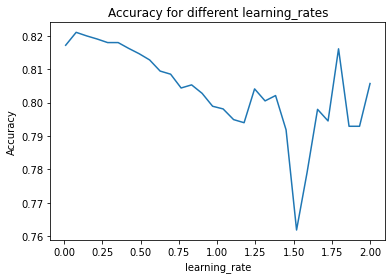

In [55]:
# Set the learning rates & accuracies list
learn_rates = np.linspace(.01, 2, num=30)
accuracies = []

# Create the for loop
for learn_rate in learn_rates:
  	# Create the model, predictions & save the accuracies as before
    model = GradientBoostingClassifier(learning_rate=learn_rate)
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

# Plot results    
plt.plot(learn_rates, accuracies)
plt.gca().set(xlabel='learning_rate', ylabel='Accuracy', title='Accuracy for different learning_rates')
plt.show()